# Chapter: Other Useful Methods

# Topic:  Determining Monitoring Metric Control Limit via KDE 

In [23]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##         Determining Monitoring Metric Control Limit via KDE
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [24]:
# import required packages
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [25]:
# fetch TE data and select variables as done in Lee et al.
TEdata_noFault_train = np.loadtxt('d00.dat').T # data arrnagement in d00.dat is different than that in other files

xmeas = TEdata_noFault_train[:,0:22]
xmv = TEdata_noFault_train[:,41:52]
data_noFault_train = np.hstack((xmeas, xmv))

In [26]:
# scale data
scaler = StandardScaler()
data_train_normal = scaler.fit_transform(data_noFault_train)
           
# fit ICA model
ica = FastICA(max_iter=1000, tol=0.005, random_state=1).fit(data_train_normal)

In [27]:
# decide # of ICs to retain via PCA variance method
from sklearn.decomposition import PCA
pca = PCA().fit(data_train_normal)

explained_variance = 100*pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance) 

n_comp = np.argmax(cum_explained_variance >= 90) + 1

In [28]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                     Monitoring statistics function
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [29]:
def compute_ICA_monitoring_metrics(ica_model, number_comp, data):
    """ calculate monitoring statistics for given data 
    
    parameters
    -----------
    data: numpy array of shape = [n_samples, n_features]
          Training or test data
    
    Returns
    ----------
    monitoring_stats: numpy array of shape = [n_samples, 3]
        
    """
    
    # data parameters
    n = data.shape[0]
    
    # model parameters
    W = ica.components_
    L2_norm = np.linalg.norm(W, 2, axis=1)
    sort_order = np.flip(np.argsort(L2_norm))    
    W_sorted = W[sort_order,:]
    
    # I2
    Wd = W_sorted[0:number_comp,:]
    Sd = np.dot(Wd, data.T)
    I2 = np.array([np.dot(Sd[:,i], Sd[:,i]) for i in range(n)]) 
        
    # Ie2
    We = W_sorted[n_comp:,:]
    Se = np.dot(We, data.T)
    Ie2 = np.array([np.dot(Se[:,i], Se[:,i]) for i in range(n)]) 
        
    # SPE
    Q = ica.whitening_
    Q_inv = np.linalg.inv(Q)
    A = ica.mixing_
    B = np.dot(Q, A)
    B_sorted = B[:,sort_order]
    Bd = B_sorted[:,0:n_comp]
    
    data_reconstruct = np.dot(np.dot(np.dot(Q_inv, Bd), Wd), data.T)
    e = data.T - data_reconstruct
    SPE = np.array([np.dot(e[:,i], e[:,i]) for i in range(n)])
    
    monitoring_stats = np.column_stack((I2, Ie2, SPE))
    return monitoring_stats

In [30]:
def draw_monitoring_chart(values, CL, yLabel):
    plt.figure()
    plt.plot(values)
    plt.axhline(CL, color = "red", linestyle = "--")
    plt.xlabel('Sample #')
    plt.ylabel(yLabel)
    plt.show()

In [31]:
def draw_ICA_monitoring_charts(ICA_statistics, CLs, trainORtest):
    """ draw monitoring charts for given data 
    
    parameters
    -----------
    ICA_statistics: numpy array of shape = [n_samples, 3]
    CLs: List of control limits
    trainORtest: 'training' or 'test'

    """
    
    # I2 chart, Ie2 chart, SPE chart
    draw_monitoring_chart(ICA_statistics[:,0], CLs[0], 'I2 for ' + trainORtest + ' data')
    draw_monitoring_chart(ICA_statistics[:,1], CLs[1], 'Ie2 for ' + trainORtest + ' data')
    draw_monitoring_chart(ICA_statistics[:,2], CLs[2], 'SPE for ' + trainORtest + ' data')

In [32]:
def get_CL_via_KDE(metric_values, percentile, metricLabel):
    """ calculate control limit for a monitoring statistic via KDE 
    
    parameters
    -----------
    metric_values: numpy array of shape = [n_samples,]
          
    """
    
    # find optimal KDE bandwidth via CV
    N = len(metric_values)
    empirical_h = 1.06*np.std(metric_values)*N**(1/5)
    h_grid = np.linspace(0,5,50)*empirical_h
    
    CV_grid = GridSearchCV(KernelDensity(),{'bandwidth': h_grid}, cv=N) # leave-one-out CV
    CV_grid.fit(metric_values[:,None]) # 2D array is expected
    optimal_h = CV_grid.best_params_['bandwidth']
    
    # compute density values via KDE 
    kde = CV_grid.best_estimator_  
    metric_grid = np.linspace(0, np.max(metric_values), 100)[:,None]
    metric_pdf_values = np.exp(kde.score_samples(metric_grid)) # pdf = probability density function
    
    # Find control limit via numerical integration
    metric_cdf_values = [np.trapz(metric_pdf_values[:i, None], metric_grid[:i,:], axis=0)[0] for i in range(100)] # cdf = cumulative density function
    metric_CL = metric_grid[np.argmax(np.array(metric_cdf_values) > percentile/100),0]
    
    # KDE plot with histogram
    plt.figure()
    plt.hist(metric_values, bins=50, color='gray', histtype='stepfilled', alpha=0.3, density=True, label='Histogram density')
    plt.plot(metric_grid, metric_pdf_values, alpha=0.5, label='KDE density')
    plt.title('h: {:.4f}; CL: {:.3f}'.format(optimal_h, metric_CL))
    plt.ylabel('density')
    plt.xlabel(metricLabel)
    plt.legend()
    plt.show()
    
    return metric_CL

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


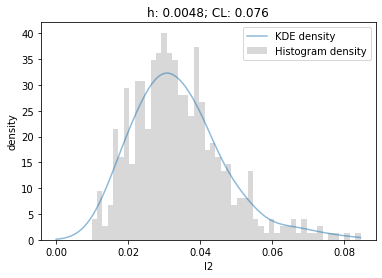

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


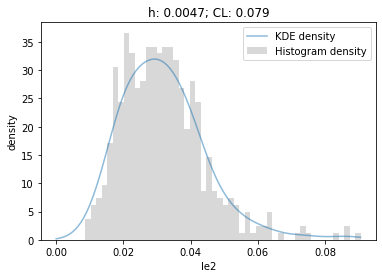

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##    Draw monitoring charts for training data with KDE-based control limits
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ICA_statistics_train = compute_ICA_monitoring_metrics(ica, n_comp, data_train_normal)
I2_CL = get_CL_via_KDE(ICA_statistics_train[:,0], 99, 'I2')
Ie2_CL = get_CL_via_KDE(ICA_statistics_train[:,1], 99, 'Ie2')
SPE_CL = get_CL_via_KDE(ICA_statistics_train[:,2], 99, 'SPE')

draw_ICA_monitoring_charts(ICA_statistics_train, [I2_CL, Ie2_CL, SPE_CL], 'training')